<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/IFR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ESTRATÉGIA
1.   IFR para 2 períodos < 5 compra na abertura seguinte
2.   Preço fechamento > ma5 vende na abertura seguinte



In [1]:
# @ Data é ano/mes/dia.

inicio  = '2020-01-02'  #@param {type:"date"}
termino = '2023-01-30'  #@param {type:"date"}


usar_periodo = True #@param {type:"boolean"}
periodo = '1y' #@param ['1d','5d','1mo','3mo','6mo','1y','2y','3y','5y','10y','ytd','max']

In [2]:
# @ markdown Instala bibliotecas

import pandas as pd
import numpy as np

# !pip install -q pyfolio
import pyfolio as pf

# !pip install -q  yfinance
import yfinance as yf

/home/yair/bin/miniconda3/lib/python3.11/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [5]:
# from datetime import date
# today = date.today().strftime('%d-%m-%y')
# arq = 'IBOVDia_'+today+'.csv'
arq = 'data/Cart_Ibov.csv'

In [7]:
try:
    IBOV = pd.read_csv(arq,encoding='latin-1',sep=';' , skiprows=[0])
    IBOV = IBOV[:-2]
except:
    url = f'https://raw.githubusercontent.com/BDonadelli/Codigos-em-financas/main/{arq}.csv'
    IBOV = pd.read_csv(url,encoding='latin-1',sep=';' , skiprows=[0])

IBOV = IBOV[:-2]

In [8]:
codigos = np.array(sorted(IBOV.index.to_list()),dtype=np.object_)
codigos

array(['ABEV3', 'ALOS3', 'ALPA4', 'ARZZ3', 'ASAI3', 'AZUL4', 'B3SA3',
       'BBAS3', 'BBDC3', 'BBDC4', 'BBSE3', 'BEEF3', 'BHIA3', 'BPAC11',
       'BRAP4', 'BRFS3', 'BRKM5', 'CCRO3', 'CIEL3', 'CMIG4', 'CMIN3',
       'COGN3', 'CPFE3', 'CPLE6', 'CRFB3', 'CSAN3', 'CSNA3', 'CVCB3',
       'CYRE3', 'DXCO3', 'EGIE3', 'ELET3', 'ELET6', 'EMBR3', 'ENEV3',
       'ENGI11', 'EQTL3', 'EZTC3', 'FLRY3', 'GGBR4', 'GOAU4', 'GOLL4',
       'HAPV3', 'HYPE3', 'IGTI11', 'IRBR3', 'ITSA4', 'ITUB4', 'JBSS3',
       'KLBN11', 'LREN3', 'LWSA3', 'MGLU3', 'MRFG3', 'MRVE3', 'MULT3',
       'NTCO3', 'PCAR3', 'PETR3', 'PETR4', 'PETZ3', 'PRIO3', 'RADL3',
       'RAIL3', 'RAIZ4', 'RDOR3', 'RECV3', 'RENT3', 'RRRP3', 'SANB11',
       'SBSP3', 'SLCE3', 'SMTO3', 'SOMA3', 'SUZB3', 'TAEE11', 'TIMS3',
       'TOTS3', 'TRPL4', 'UGPA3', 'USIM5', 'VALE3', 'VAMO3', 'VBBR3',
       'VIVT3'], dtype=object)

In [9]:
# @ markdown ## download dados do yahoo finance
## a ultima lina da tabela tem a data mais recente
df=pd.DataFrame()
if usar_periodo : 
  df = yf.download(tickers=(codigos+'.SA').tolist(), period = periodo   , auto_adjust=True, progress = False )[['Open','Close']]
else: 
  df = yf.download(tickers=(codigos+'.SA').tolist(), start = inicio , end = termino , auto_adjust=True, progress = False )[['Open','Close']]

d = dict(zip(df.columns.levels[1],df.columns.levels[1].str.rstrip('.SA') ))
df = df.rename(columns=d, level=1)

df.columns = [" ".join(col).strip() for col in df.columns.values]
df.head(1) #mostra a primeiro linha da tabela dos preços

,Open ABEV3,Open ALOS3,Open ALPA4,Open ARZZ3,Open ASAI3,Open AZUL4,Open B3SA3,Open BBAS3,Open BBDC3,Open BBDC4,...,Close TAEE11,Close TIMS3,Close TOTS3,Close TRPL4,Close UGPA3,Close USIM5,Close VALE3,Close VAMO3,Close VBBR3,Close VIVT3
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-16,13.038481,NaN,13.49,75.94069,19.759319,11.59,12.736999,32.910658,12.236115,13.903922,...,32.823181,11.035098,27.253855,20.491703,12.094959,7.382604,86.762772,11.922291,14.196237,36.396473


In [10]:
# @ markdown  função que calcula o ifr a partir de uma serie de preços

def rsi(price, window=2):   
  '''
    calcula o ifr 
    "price" é uma série de preços
    "window" é o periodo da janela móvel de obeservação, por default vale 2       
    Referencia: https://seekingalpha.com/article/4518407-rsi-indicator-meaning-and-calculation 
  '''
    
  data = pd.DataFrame(price).copy()
    
  data["Variation"] = data.diff()

  data["Gain"] = np.where(data["Variation"] > 0, data["Variation"], 0)
  data["Loss"] = np.where(data["Variation"] < 0, data["Variation"], 0)

  initial_avg_gain = data["Gain"].rolling(window).mean()
  initial_avg_loss = data["Loss"].abs().rolling(window).mean()

  avg_gain = initial_avg_gain
  avg_loss = initial_avg_loss
  for i in range(window, len(avg_gain)):
     avg_gain.iloc[i] = (avg_gain.iloc[i - 1] * (window - 1) + data["Gain"].iloc[i]) / window
     avg_loss.iloc[i] = (avg_loss.iloc[i - 1] * (window - 1) + data["Loss"].abs().iloc[i]) / window
  rsi = 100 - (100 / (1 + ( avg_gain / avg_loss )))
  return rsi

**lista os ativos do índice com ifr2 < 5**


In [11]:
IFR = pd.DataFrame({f"{i}": rsi( df['Close '+i] , 2)  for i in codigos})

print('o ultimo preço é do dia',IFR.index[-1].day,'/',IFR.index[-1].month,'/',IFR.index[-1].year)
print('Os ativos com IFR<5 são:')
## seleciona os ativos dentre 'codigos' com ifr2 < 5 
lista_ifr=[]
for x in codigos :
  if IFR[x].iloc[-1]< 5 :  
    print(x)
    lista_ifr.append(x)

if len(lista_ifr)==0: print('Não tem papel com IFR<5')

o ultimo preço é do dia 16 / 1 / 2024
Os ativos com IFR<5 são:
ALPA4
ARZZ3
AZUL4
BRAP4
CIEL3
CMIN3
CSNA3
FLRY3
GGBR4
GOLL4
RADL3
SANB11
SOMA3
VALE3


**histórico da estratégia**

In [12]:
# @ markdown Simula as operações
def trades (x):
  '''
  'trades' cria duas listas 'entrada' e 'saida' 
  essas listas têm 3 componentes: 
    a linha na tabela de dados do sinal de entrada/saida;
    a data seguinte do sinal (entrada/saida) e 
    o preço (open) de entrada/saida naquele dia
  '''
  open  = 'Open '+x
  close = 'Close '+x

  bt = df[[open , close]].copy() 
  #media movel simples de 5 periodos 
  bt['mm5'] = df[close].rolling(5).mean()  
  bt['ifr'] = IFR[x]
  bt=bt.dropna()

  ## marca todos os pontos com ifr2 < 5
  bt['sinal_entra'] = np.where(bt['ifr'] < 5 , 1 , 0)
  #marca todos pontos com close > mm5
  bt['sinal_sai'] = np.where(bt[close] > bt['mm5'] , -1 , 0)

  '''
  cria listas com os pontos de entrada e saída das operações
  1) percorre a tabela bt em ordem cronológica até achar sinal entrada
     quando acha, armazenas as informações: 
       linha da tabela, data do sinal e preço de abertura do dia seguinte
  2) em seguida, continua, a partir do proximo dia, até achar sinal saida
     quando acha, armazenas as informações: 
       linha da tabela, data do sinal e preço de fechamento do dia seguinte
  3) repete os passos 1 e 2 
  '''  
  entrada = []
  saida = []
  i=0
  while i < len(bt):
    while bt['sinal_entra'][i] == 0 : i+=1      #pega um sinal de entrada
    if i+1 < len(bt) :                          #se teve pregão dia seguinte,entra
        i+=1
        entrada.append( ( i-1, 
                         bt.index[i].date().strftime("%d/%m/%Y") , 
                         np.round(bt[open].iloc[i],2)))  
       #avança até o primeiro sinal de saída, que pode ser no proprio dia
        while (i < len(bt) and bt['sinal_sai'].iloc[i]==0) : i=i+1    
       #se teve pregão dia seguinte,sai  
        if i+1 < len(bt) :  
            i+=1
            saida.append( (i-1, 
                           bt.index[i].date().strftime("%d/%m/%Y")  , 
                           np.round(bt[open].iloc[i],2)) )  
            # senão, a ultima operação ainda não deu saida 
        else : entrada.pop()                    
    i=i+1
  return entrada,saida

In [13]:
# @ markdown Mostra os resultados

resumo = pd.DataFrame(index=lista_ifr,columns=['IFR2',                    # ifr do papel
                                               'Operações' ,              # no. de operações no periodo
                                               'Retornos positivos' ,     # no. de operações com retorno >0
                                               'acerto/erro' ,              # Retornos positivos / Retornos negativos
                                               'Acumulado',               # Retorno acumulado pela estratégia 
                                               'Retorno médio' ,          # média aritmetica dos retornos de cada operação
                                               'Duração média(dias)' ])   # no. medio de dias que fica posicionado

# usando as informações da função 'trades', simula as operações
# calcula o tempo de cada operação e a variação do preço do ativo

out =  [ [[],[]] for j in range(len(lista_ifr))] 
retornos = [ [[],[]] for j in range(len(lista_ifr))] 
z=0
for x in lista_ifr:
  dura = []  ## duração da operação, em dias uteis
  e    = []  ## pontos de entrada 
  s    = []  ## pontos de saida
  posret = 0 ## conta retornos positivos

  e,s = trades(x)
  # mensagens para ajudar na validação
  out1 =  ['' for j in range(len(e))] 
  out2 =  ['' for j in range(len(e))] 
  out3 =  ['' for j in range(len(e))] 
  for j in range(len(e)) :
      out1[j] =  "entrada em " + str(e[j][1]) + " e saida em " + str(s[j][1]) 
      
      dias = s[j][0] - e[j][0]
      out2[j] = " durou "+str(dias)+" dias e "
      dura.append(dias)

      retorno = s[j][2]/e[j][2] - 1
      out3[j] = "variou "+str(round(retorno*100,3))+"%" 
      retornos[z][1].append(retorno)
      if retorno > 0 : posret +=1
  
  if len(e)-posret!=0 : wins = np.round(posret/(len(e)-posret),3) 
  else : wins = 0
  resumo.loc[x] = [ IFR[x][-1].round(2), 
                   len(e) , 
                   posret , 
                   wins,
                   np.round((np.array(retornos[z][1])+1).cumprod()[-1],2) , 
                   np.round(np.mean(retornos[z][1])*100,2) , np.round(np.mean(dura),1) 
                   ]
  
  retornos[z][0] = x
  out[z][0] = x
  for j in range(len(e)) : 
        out[z][1].append(out1[j] + out2[j]+out3[j])        
  z=z+1

resumo.sort_values(by=['acerto/erro'], ascending=False)

/tmp/ipykernel_42639/2623174244.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while bt['sinal_entra'][i] == 0 : i+=1      #pega um sinal de entrada
/tmp/ipykernel_42639/1356206148.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resumo.loc[x] = [ IFR[x][-1].round(2),
/tmp/ipykernel_42639/2623174244.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  while bt['sinal_entra'][i] == 0 : i+=1      #pega um sinal de entrada
/t

,IFR2,Operações,Retornos positivos,acerto/erro,Acumulado,Retorno médio,Duração média(dias)
ARZZ3,3.79,10,9,9.0,1.32,2.85,3.2
VALE3,3.43,9,8,8.0,1.22,2.25,3.1
ALPA4,4.24,12,10,5.0,1.17,1.6,4.0
AZUL4,1.61,7,5,2.5,1.0,0.57,5.3
BRAP4,0.99,9,6,2.0,1.08,0.88,4.4
CSNA3,1.08,8,5,1.667,1.02,0.24,4.9
SOMA3,2.99,9,5,1.25,0.91,-0.82,4.7
GGBR4,4.05,4,2,1.0,0.95,-1.26,7.0
RADL3,0.53,6,3,1.0,1.04,0.64,4.8
SANB11,0.53,6,3,1.0,0.96,-0.55,5.8


**informações dos trades**

In [14]:
for x in range(len(lista_ifr)):
  print("\n******",retornos[x][0],"********")
  print('resumo dos retornos das operações:')
  print(pd.Series(retornos[x][1]).describe()  );


****** ALPA4 ********
resumo dos retornos das operações:
count    12.000000
mean      0.016001
std       0.080059
min      -0.201288
25%       0.004260
50%       0.013845
75%       0.047325
max       0.114846
dtype: float64

****** ARZZ3 ********
resumo dos retornos das operações:
count    10.000000
mean      0.028470
std       0.016853
min       0.000000
25%       0.017578
50%       0.025394
75%       0.042025
max       0.055948
dtype: float64

****** AZUL4 ********
resumo dos retornos das operações:
count    7.000000
mean     0.005655
std      0.112584
min     -0.211996
25%     -0.015000
50%      0.027445
75%      0.053182
max      0.147770
dtype: float64

****** BRAP4 ********
resumo dos retornos das operações:
count    9.000000
mean     0.008815
std      0.033676
min     -0.036594
25%     -0.028504
50%      0.023154
75%      0.030678
max      0.049980
dtype: float64

****** CIEL3 ********
resumo dos retornos das operações:
count    5.000000
mean    -0.052500
std      0.079954
min 

In [15]:
out

[['ALPA4',
  ['entrada em 07/02/2023 e saida em 17/02/2023 durou 8 dias e variou -20.129%',
   'entrada em 21/03/2023 e saida em 29/03/2023 durou 6 dias e variou 0.479%',
   'entrada em 06/04/2023 e saida em 11/04/2023 durou 2 dias e variou 11.485%',
   'entrada em 19/04/2023 e saida em 02/05/2023 durou 7 dias e variou 3.347%',
   'entrada em 28/06/2023 e saida em 04/07/2023 durou 4 dias e variou 1.528%',
   'entrada em 14/07/2023 e saida em 18/07/2023 durou 2 dias e variou 1.143%',
   'entrada em 04/08/2023 e saida em 09/08/2023 durou 3 dias e variou 11.466%',
   'entrada em 22/08/2023 e saida em 24/08/2023 durou 2 dias e variou 5.263%',
   'entrada em 31/08/2023 e saida em 05/09/2023 durou 3 dias e variou -1.444%',
   'entrada em 20/09/2023 e saida em 21/09/2023 durou 1 dias e variou 1.241%',
   'entrada em 11/10/2023 e saida em 24/10/2023 durou 8 dias e variou 0.267%',
   'entrada em 27/11/2023 e saida em 29/11/2023 durou 2 dias e variou 4.556%']],
 ['ARZZ3',
  ['entrada em 13/02/20

# daqui pra baixo são testes de códigos

In [16]:
#biblioteca *pronta* para o ifr
# !pip install -q  pandas_ta
import pandas_ta as pta
# cria uma tabela com o ifr2 do pandas_ta
IFR2 = pd.DataFrame({f"{i}": pta.rsi( df['Close '+i] , 2)  for i in codigos})
IFR2.tail(1)

,ABEV3,ALOS3,ALPA4,ARZZ3,ASAI3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,...,TAEE11,TIMS3,TOTS3,TRPL4,UGPA3,USIM5,VALE3,VAMO3,VBBR3,VIVT3
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-16,6.345132,9.922845,4.242694,3.793701,59.609634,1.606023,27.34194,65.704346,8.398809,13.161281,...,42.757487,32.950824,18.238609,23.546887,24.828285,19.541853,3.427378,9.437721,16.093606,54.956462


In [17]:
x='RECV3'
open  = 'Open'
close = 'Close'

In [18]:
import cufflinks as cf
ativo = yf.download(tickers= x+'.SA', period = periodo , auto_adjust=True, progress = False )

qf=cf.QuantFig(ativo , title= x ,legend='top',name='GS',up_color='green', down_color='red' )
#qf.add_bollinger_bands(periods=20, boll_std=2, colors=['cyan','grey'], fill=True)
qf.add_ema(periods=9)
qf.add_ema(periods=21)
qf.add_ema(periods=72)

fig = qf.figure()
fig.update_xaxes(
    rangebreaks=[dict(bounds=["sat", "mon"])])
fig.show()

In [19]:
bt = ativo[[open , close]].copy() 
bt['retorno'] = np.log(ativo[close]/ativo[close].shift(1)) 
bt['mms5'] = ativo[close].rolling(5).mean()  #media movel simples de 5 periodos 
bt['ifr2'] = IFR2[x]
bt=bt.dropna()

In [20]:
## marca todos os pontos com ifr2 < 5
bt['sinal_entra'] = np.where(bt['ifr2'] < 5 , 1 , 0)
  #marca todos pontos com close > mm5
bt['sinal_sai']   = np.where(bt[close] > bt['mms5'] , 1 , 0)

In [21]:
bt['posicao']=0 #df['posicao'] = pd.Series([1 for x in range(len(bt.index))])

In [22]:
entrada = []
saida = []
i=0
while i < len(bt):
  while bt['sinal_entra'][i] == 0 : i+=1      #pega um sinal de entrada
  #se teve pregão dia seguinte,entra
  if i+1 < len(bt) :      
    i+=1
    bt.loc[bt.index[i],'posicao'] = 1
    entrada.append( ( i-1,                                      # sinal
                      bt.index[i].date().strftime("%d/%m/%Y") ,  # data entrada
                      np.round(bt[open].iloc[i],2)))             # preço entrada
     #avança até o primeiro sinal de saída, que pode ser no proprio dia
    while (i < len(bt) and bt['sinal_sai'].iloc[i]==0) : 
      bt.loc[bt.index[i],'posicao'] = 1 
      i=i+1    
    if i < len(bt) : bt.loc[bt.index[i],'posicao'] = 1  
    #se teve pregão dia seguinte,sai  
    if i+1 < len(bt) :  
      i+=1
      saida.append( (i-1,                                       # sinal
                     bt.index[i].date().strftime("%d/%m/%Y")  , # data saida
                     np.round(bt[open].iloc[i],2)) )            # preço saida
    # senão, a ultima operação ainda não deu saida 
    else : entrada.pop()                    
  i=i+1


/tmp/ipykernel_42639/2563083660.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



IndexError: index 245 is out of bounds for axis 0 with size 245

In [ ]:
bt[bt.index.month==6]

,Open,Close,retorno,mms5,ifr2,sinal_entra,sinal_sai,posicao
Date,,,,,,,,
2022-06-01 00:00:00-03:00,28.221622,27.849123,-0.011201,28.594118,15.583093,0,0,0
2022-06-02 00:00:00-03:00,27.878531,27.555046,-0.010616,28.407870,9.921993,0,0,0
2022-06-03 00:00:00-03:00,27.829517,26.878668,-0.024853,27.902057,3.714553,1,0,0
2022-06-06 00:00:00-03:00,25.976831,25.604334,-0.048571,27.209995,1.106371,1,0,1
2022-06-07 00:00:00-03:00,25.476899,25.231834,-0.014655,26.623801,0.784387,1,0,1
2022-06-08 00:00:00-03:00,25.055387,25.957224,0.028343,26.245421,53.495602,0,0,1
2022-06-09 00:00:00-03:00,25.663149,26.261106,0.011639,25.986633,67.819937,0,1,1
2022-06-10 00:00:00-03:00,25.839594,25.996435,-0.010130,25.810187,44.137754,0,1,0
2022-06-13 00:00:00-03:00,25.437689,24.339800,-0.065847,25.557280,8.217274,0,0,0


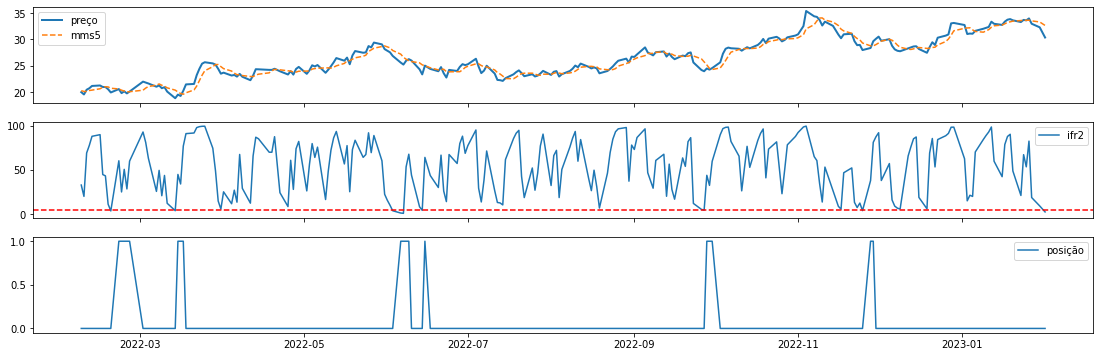

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
_, axarr = plt.subplots(3, sharex=True ,figsize=(19,6) )
axarr[0].plot(bt.index , bt[close] , label='preço', linewidth=2) 
axarr[0].plot(bt.index , bt['mms5'] , label= 'mms5', linestyle = '--') 
axarr[0].legend()
axarr[1].plot(bt.index , bt['ifr2'], label='ifr2')
axarr[1].axhline(y = 5.01, color = 'r', linestyle = '--')
axarr[1].legend()
axarr[2].plot(bt.index , bt['posicao'], label='posição' )
axarr[2].legend()
plt.show()

In [ ]:
## calculating stretegy returns
bt['retorno_estrategia'] = bt['retorno'] * (bt['posicao'].shift(1))
bt.fillna(0,inplace=True)
bt

,Open,Close,retorno,mms5,ifr2,sinal_entra,sinal_sai,posicao,retorno_estrategia
Date,,,,,,,,,
2022-02-07 00:00:00-03:00,20.681844,20.000240,-0.039146,20.286514,32.857152,0,0,0,0.0
2022-02-08 00:00:00-03:00,19.961291,19.562065,-0.022152,20.130719,19.999953,0,0,0,-0.0
2022-02-09 00:00:00-03:00,19.532852,20.457888,0.044776,20.146298,69.230737,0,1,0,0.0
2022-02-10 00:00:00-03:00,20.467626,20.740267,0.013709,20.311831,77.831294,0,1,0,0.0
2022-02-11 00:00:00-03:00,20.827902,21.178442,0.020907,20.387780,88.129019,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...
2023-01-25 00:00:00-03:00,33.700001,33.619999,-0.002673,33.624000,53.524496,0,0,0,-0.0
2023-01-26 00:00:00-03:00,33.799999,33.990002,0.010945,33.650000,82.670601,0,1,0,0.0
2023-01-27 00:00:00-03:00,33.500000,32.980000,-0.030165,33.520000,18.687844,0,0,0,-0.0


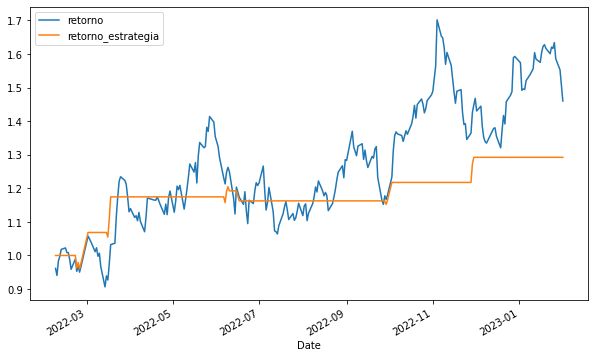

In [ ]:
bt[['retorno', 'retorno_estrategia']].cumsum().apply(np.exp).plot(figsize=(10, 6));

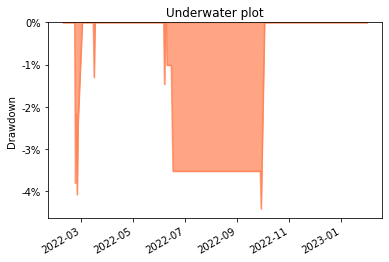

In [ ]:
pf.plot_drawdown_underwater(bt['retorno_estrategia'])